# Libraries

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
%matplotlib inline

# Upload data

In [46]:
df = pd.read_csv('/content/drive/MyDrive/Colab_data/bitstampUSD.csv.gz', compression='gzip')
df.rename(columns={
    "1315922016": "Timestamp",
    "5.800000000000": "Price",
    "1.000000000000": "Volume"
}, inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index("Timestamp", inplace=True)

df['Price_by_Volume'] = df['Price'] * df['Volume']
df_vwap = df.resample('T').sum()
df_vwap['Weighted_Price'] = df_vwap['Price_by_Volume'] / df_vwap['Volume']

df_ohlc = df['Price'].resample('T').ohlc()
df_ohlc = df_ohlc.join(df_vwap[['Volume', 'Price_by_Volume', 'Weighted_Price']])

df = df_ohlc

In [47]:
# Resampling to monthly frequency
df_month = df.resample('M').mean()
df_month_train, df_month_test = df_month[:'2021-02-01'], df_month['2021-02-01':]

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()
train_y, test_y = df_year[:'2021-02-01'], df_year['2021-02-01':]

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()
train_q, test_q = df_Q[:'2021-02-01'], df_Q['2021-02-01':]


# EDA

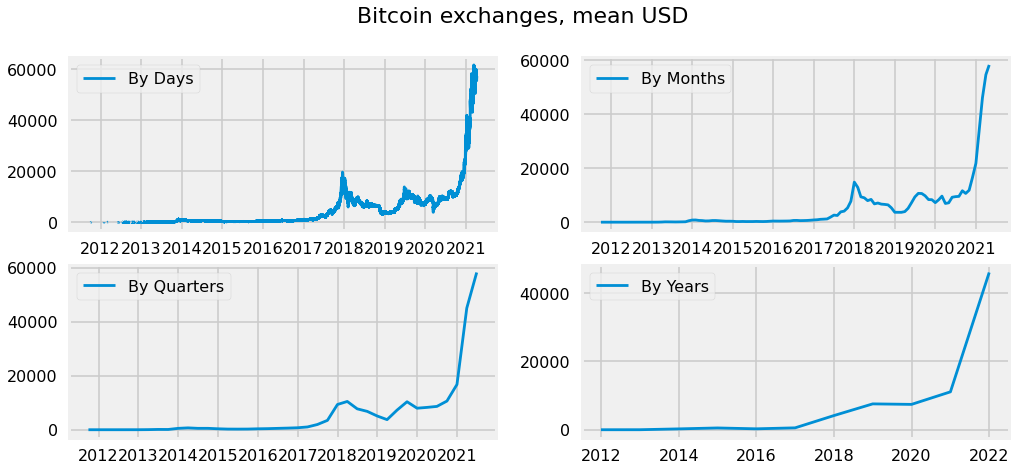

In [48]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

# Check stationarity

Next will be working with train data

<Figure size 1080x504 with 0 Axes>

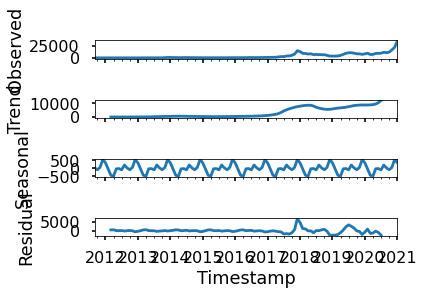

In [6]:
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_month_train.Weighted_Price).plot()
# print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month_train.Weighted_Price)[1])
plt.show()

The series is not stationarity

# Logarithm

In [7]:
df_month_train, df_month_test = np.log(df_month_train), np.log(df_month_test)

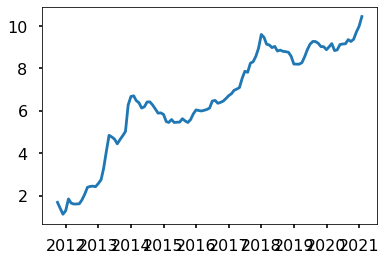

In [8]:
plt.plot(df_month_train.Weighted_Price, '-', label='Train set by Month')

# Box-Cox transformation

In [9]:
df_month_train['Weighted_Price_box'], lmbda = stats.boxcox(df_month_train.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month_train.Weighted_Price_box)[1])

Dickey–Fuller test: p=0.809351


The series is not stationarity

# Seasonal differentiation

In [10]:
df_month_train['prices_box_diff'] = df_month_train.Weighted_Price_box - df_month_train.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month_train.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.231303


It did not help

# Regular differentiation

Dickey–Fuller test: p=0.000262


<Figure size 1440x1440 with 0 Axes>

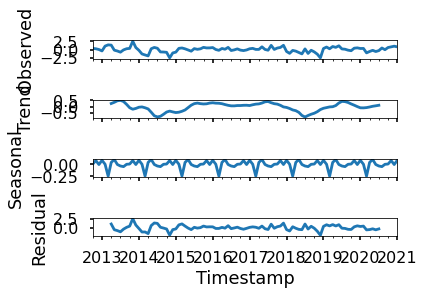

In [11]:
df_month_train['prices_box_diff2'] = df_month_train.prices_box_diff - df_month_train.prices_box_diff.shift(1)
plt.figure(figsize=(20,20))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month_train.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month_train.prices_box_diff2[13:])[1])

plt.show()

Series is stationarity

# ACF and PACF

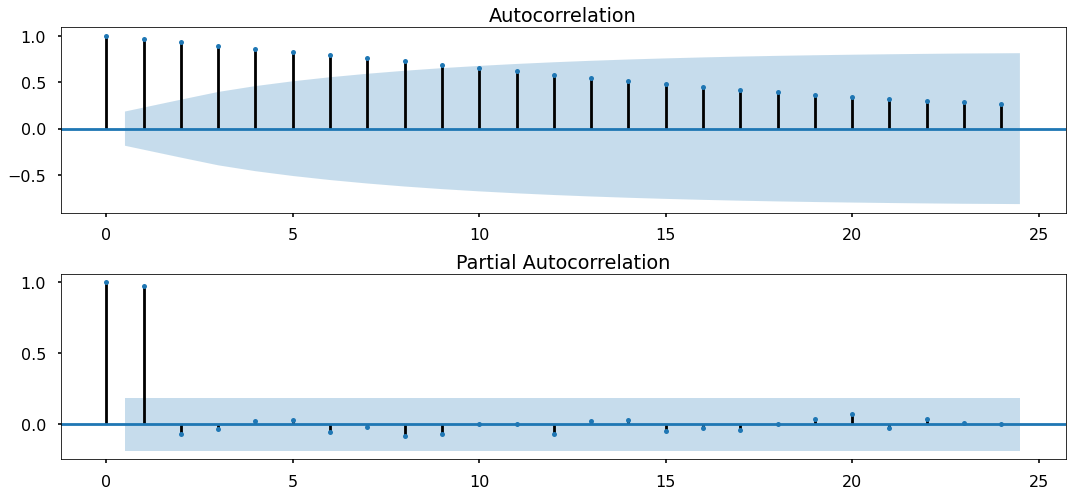

In [12]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month_train.Weighted_Price_box.values.squeeze(), lags=24, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month_train.Weighted_Price_box.values.squeeze(), lags=24, ax=ax)
plt.tight_layout()
plt.show()

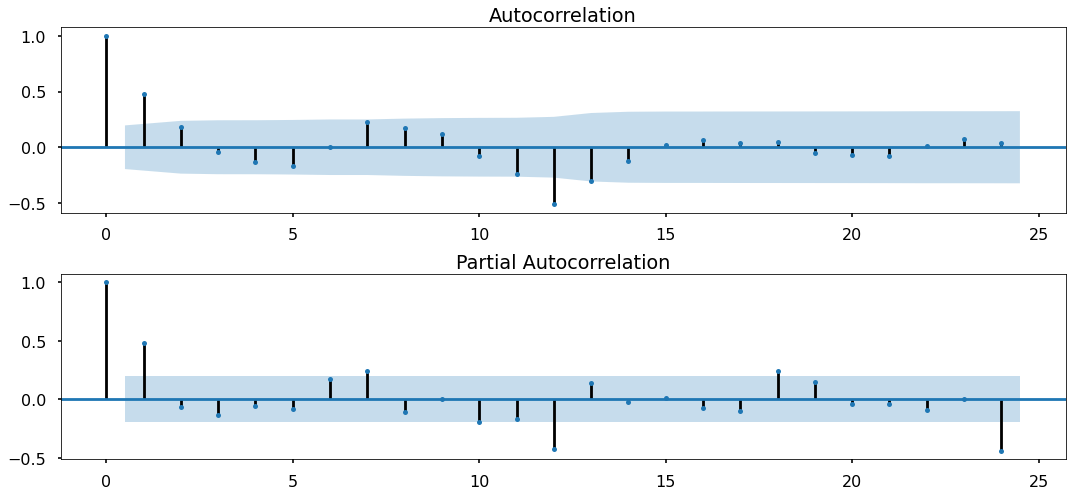

In [13]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month_train.prices_box_diff2[13:].values.squeeze(), lags=24, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month_train.prices_box_diff2[13:].values.squeeze(), lags=24, ax=ax)
plt.tight_layout()
plt.show()

# ARMA

In [14]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [15]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.ARMA(df_month_train.Weighted_Price_box, order=(param[0], param[1])).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

arma_model = best_model

wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 2, 2, 0)
wrong parameters: (0, 2, 2, 1)


In [16]:
print(best_model.summary())

                              ARMA Model Results                              
Dep. Variable:     Weighted_Price_box   No. Observations:                  113
Model:                     ARMA(2, 0)   Log Likelihood                 -79.109
Method:                       css-mle   S.D. of innovations              0.475
Date:                Tue, 18 May 2021   AIC                            166.218
Time:                        11:35:45   BIC                            177.128
Sample:                    09-30-2011   HQIC                           170.645
                         - 01-31-2021                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       10.0952      6.628      1.523      0.131      -2.896      23.086
ar.L1.Weighted_Price_box     1.4509      0.086     16.911      0.000       1.283       1.

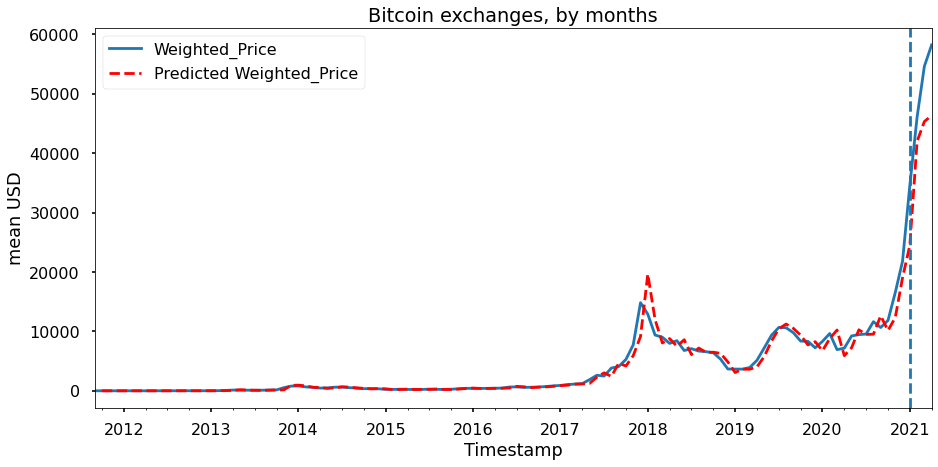

In [17]:
df_month2 = df_month[["Weighted_Price"]].copy()
df_month2['forecast'] = np.exp(invboxcox(best_model.predict(start=1, end=df_month2.index[-1]), lmbda))
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.axvline(x=df_month_train.index[-1], ls='--')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()
arma_pred = df_month2

# ARIMA

In [18]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.ARIMA(df_month_train.Weighted_Price_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

arima_model = best_model

In [19]:
print(best_model.summary())
results[:5]

                              ARIMA Model Results                               
Dep. Variable:     D.Weighted_Price_box   No. Observations:                  112
Model:                   ARIMA(0, 1, 1)   Log Likelihood                 -73.348
Method:                         css-mle   S.D. of innovations              0.465
Date:                  Tue, 18 May 2021   AIC                            152.695
Time:                          11:35:49   BIC                            160.851
Sample:                      10-31-2011   HQIC                           156.004
                           - 01-31-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.1605      0.062      2.606      0.010       0.040       0.281
ma.L1.D.Weighted_Price_box     0.4037      0.083      4.877      0.

[[(0, 0, 0, 0), 169.3678461214443],
 [(0, 0, 0, 1), 169.3678461214443],
 [(0, 0, 1, 0), 169.3678461214443],
 [(0, 0, 1, 1), 169.3678461214443],
 [(0, 0, 2, 0), 169.3678461214443]]

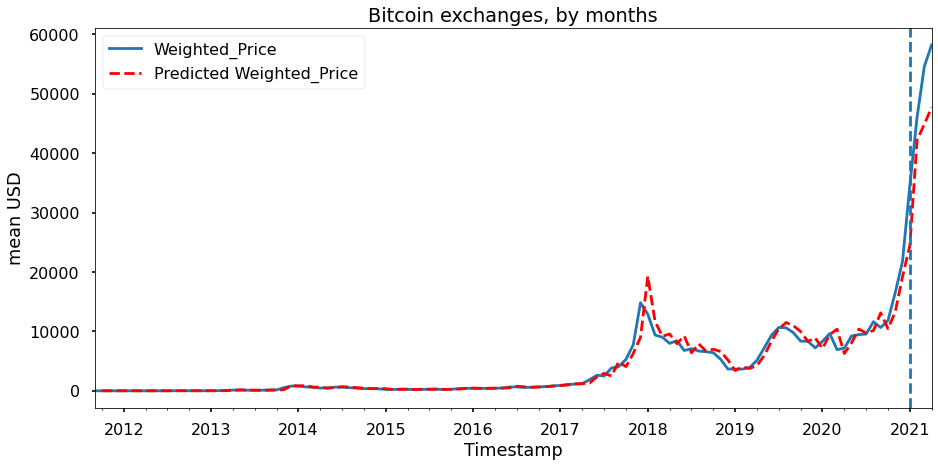

In [20]:
df_month2 = df_month[["Weighted_Price"]].copy()
df_month2['forecast'] = np.exp(invboxcox(best_model.predict(start=1, end=df_month2.index[-1], typ='levels'), lmbda))
arima_pred = df_month2
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.axvline(x=df_month_train.index[-1], ls='--')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

# SARIMAX

In [21]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month_train.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

sarimax_model = best_model

In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  167.205310
7   (0, 1, 0, 1)  167.950228
21  (1, 0, 1, 1)  168.728527
25  (1, 1, 0, 1)  168.844826
37  (2, 0, 0, 1)  168.865809
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                  113
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                 -80.603
Date:                            Tue, 18 May 2021   AIC                            167.205
Time:                                    11:36:49   BIC                            175.021
Sample:                                09-30-2011   HQIC                           170.368
                                     - 01-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


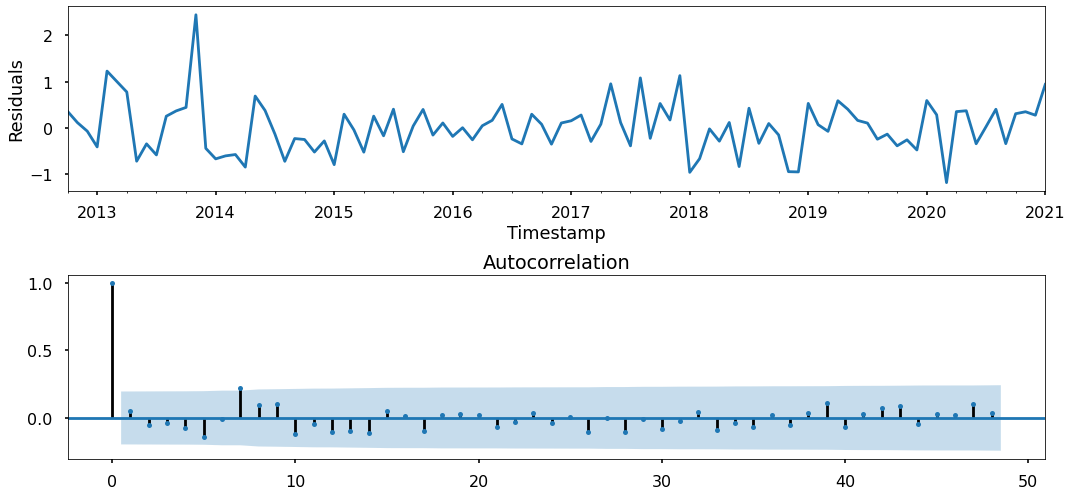

In [23]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

# Prediction

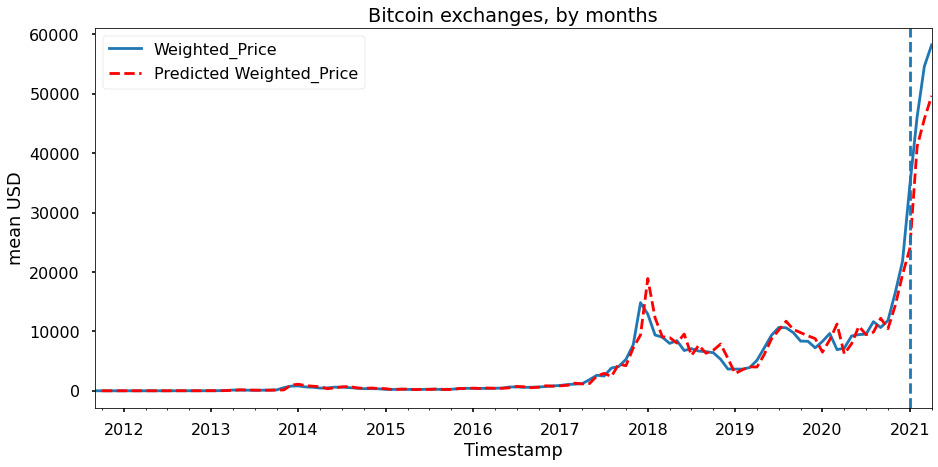

In [24]:
# Prediction
# future = pd.DataFrame(index=pd.date_range(start=df_month.index[-1], end='2021-08-01', freq='M'), columns=df_month_train.columns)
# df_month2 = pd.concat([df_month, future])
df_month2 = df_month[['Weighted_Price']]
df_month2['forecast'] = np.exp(invboxcox(best_model.predict(start=1, end=df_month_test.index[-1]), lmbda))
sarimax_pred = df_month2
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.axvline(x=df_month_train.index[-1], ls='--')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

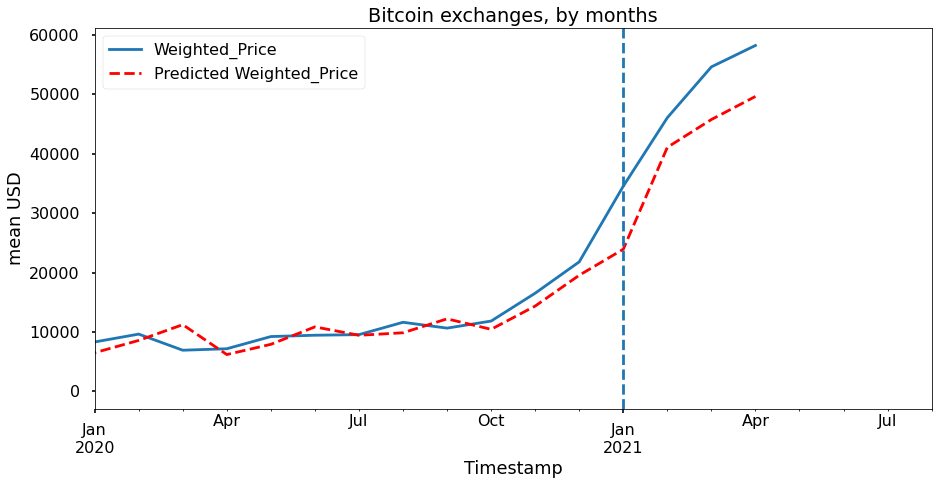

In [25]:
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.axvline(x=df_month_train.index[-1], ls='--')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.xlim(('2020-01-01', '2021-08-01'))
plt.show()

In [58]:
rmse = np.sqrt(np.mean(((df_month2.Weighted_Price - df_month2.forecast) ** 2)))
rmse

1968.007754140674

## Metrics

In [27]:
from sklearn.metrics import r2_score

models = {
    'ARMA': [arma_model, arma_pred],
    'ARIMA': [arima_model, arima_pred],
    'SARIMAX': [sarimax_model, sarimax_pred]
}

result = pd.DataFrame(index=['ARMA', 'ARIMA', 'SARIMAX'], columns=['R2', 'SSR', 'AIC', 'DW' ])
result = result.T
for model in models:

    result[model][0] = r2_score(models[model][1]['Weighted_Price'][1:], models[model][1]['forecast'][1:])
    result[model][1] = sum(models[model][0].resid**2)
    result[model][2] = models[model][0].aic
    result[model][3] = sm.stats.stattools.durbin_watson(models[model][0].resid)

result.T

,R2,SSR,AIC,DW
ARMA,0.950456,112.127,166.218,1.14832
ARIMA,0.953669,24.2971,152.695,1.89517
SARIMAX,0.957016,32.1539,167.205,1.86778


In [ ]:
df_month.tail(6)

,open,high,low,close,Volume,Price_by_Volume,Weighted_Price
Timestamp,,,,,,,
2020-11-30,16535.778528,16545.663704,16525.571002,16536.023486,6.672229,110641.638111,16535.990325
2020-12-31,21811.751812,21826.119052,21796.889787,21812.155606,5.738927,129159.516426,21811.782847
2021-01-31,34554.125793,34594.169353,34512.497779,34554.252479,10.247778,352328.559036,34552.337249
2021-02-28,46077.343214,46117.833367,46036.025287,46077.905341,5.961076,274177.247419,46075.783298
2021-03-31,54636.323944,54671.945826,54600.898304,54637.532188,3.537173,192787.852103,54634.826353
2021-04-30,58237.453287,58261.187434,58213.045546,58237.757633,1.920914,111283.286427,58235.493864


# Prediction for 5 periods

In [ ]:
df_month_train, df_month_test = np.log(df_month[:'2020-11-30']), np.log(df_month['2020-11-30':])
df_month_train['Weighted_Price_box'], lmbda = stats.boxcox(df_month_train.Weighted_Price)
df_month_train['prices_box_diff'] = df_month_train.Weighted_Price_box - df_month_train.Weighted_Price_box.shift(12)
df_month_train['prices_box_diff2'] = df_month_train.prices_box_diff - df_month_train.prices_box_diff.shift(1)

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month_train.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

sarimax_model = best_model

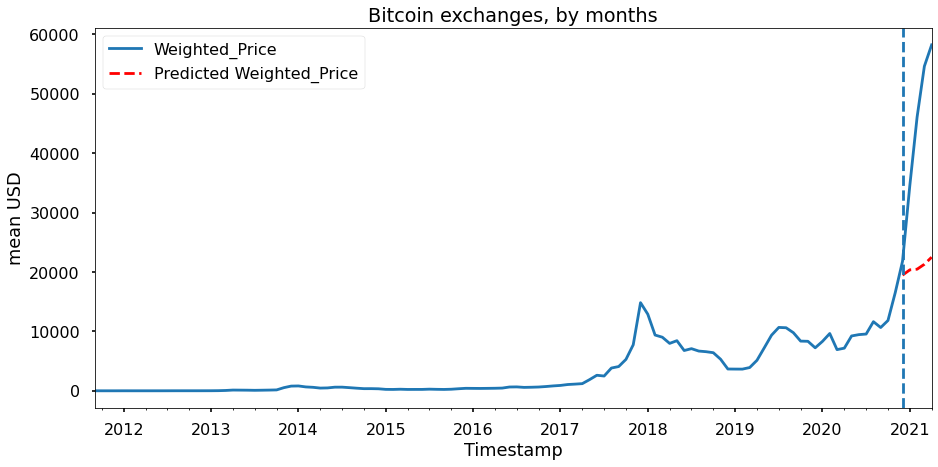

In [ ]:
# Prediction
# future = pd.DataFrame(index=pd.date_range(start=df_month.index[-1], end='2021-08-01', freq='M'), columns=df_month_train.columns)
# df_month2 = pd.concat([df_month, future])
df_month2 = df_month[['Weighted_Price']]
df_month2['forecast'] = np.exp(invboxcox(best_model.predict(start=df_month_test.index[1], end=df_month_test.index[-1]), lmbda))
sarimax_pred = df_month2
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.axvline(x=df_month_test.index[1], ls='--')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

In [ ]:
 df_month2['forecast'].tail(7)

Timestamp
2020-10-31             NaN
2020-11-30             NaN
2020-12-31    19470.083762
2021-01-31    20363.016185
2021-02-28    20473.550225
2021-03-31    21302.181104
2021-04-30    22495.921088
Freq: M, Name: forecast, dtype: float64

In [ ]:
r2_5 = r2_score(sarimax_pred['Weighted_Price'][-5:], sarimax_pred['forecast'][-5:])
ssr_5 = sum(sarimax_model.resid**2)
aic_5 = sarimax_model.aic
dw_5 = sm.stats.stattools.durbin_watson(sarimax_model.resid)

print(r2_5, ssr_5, aic_5, dw_5, sep='\n')

-2.622997216685503
33.38428936779441
169.526199196821
1.878734469668133


# ARCH

In [29]:
pip install arch

     |████████████████████████████████| 808kB 8.9MB/s 


In [30]:
import os
import pandas as pd
import numpy as np
import random
import itertools
from arch import arch_model
from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
%matplotlib inline

In [37]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15)
    plt.show()

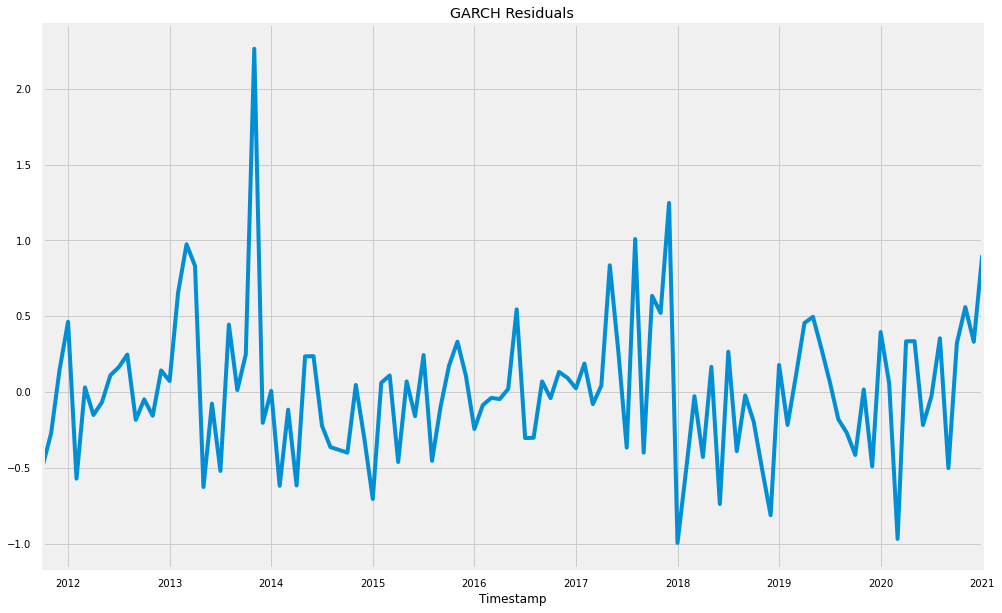

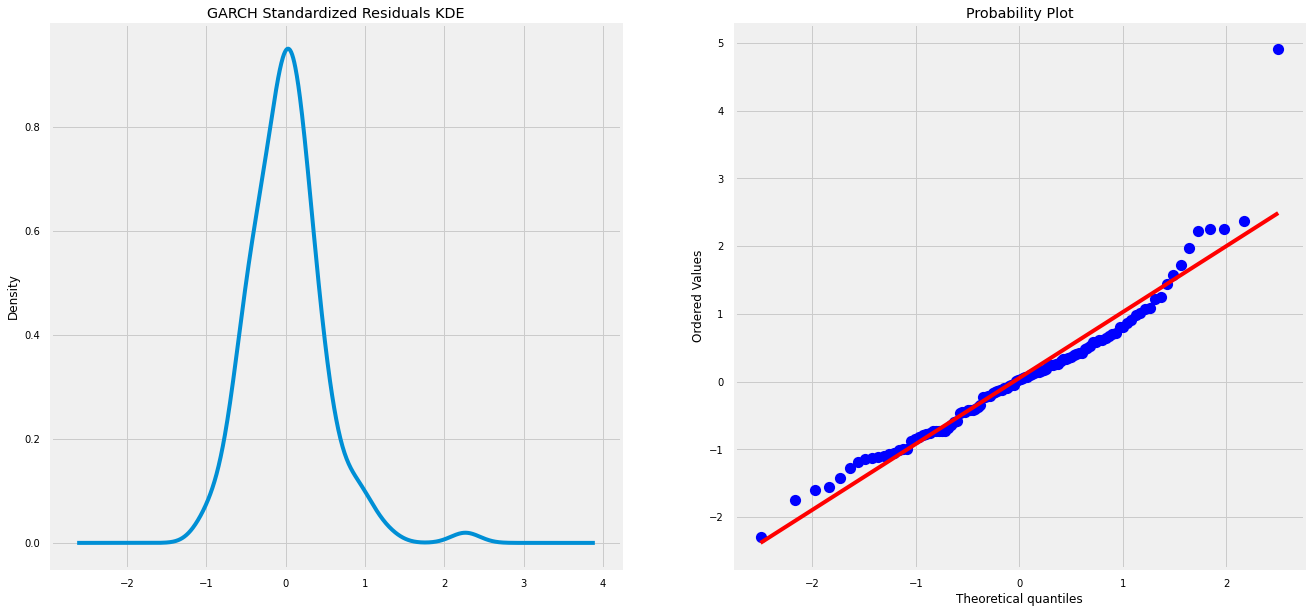

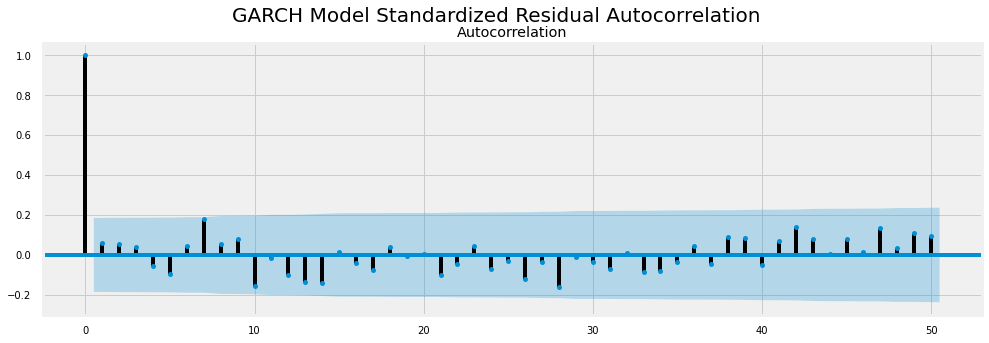

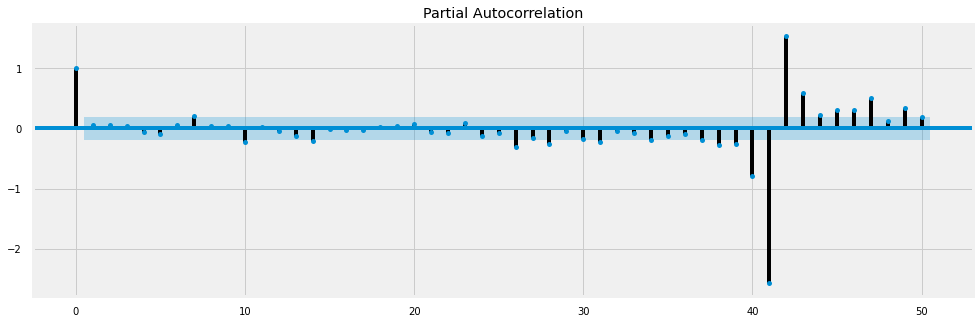

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -72.5904
Distribution:                  Normal   AIC:                           153.181
Method:            Maximum Likelihood   BIC:                           164.055
                                        No. Observations:                  112
Date:                Tue, May 18 2021   Df Residuals:                      111
Time:                        14:18:45   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0136  4.497e-02     -0.303      0.762 [ -0.102,7.451e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0316  2.713e-02      1.164      0.244 [-2.159e-02,8.475e-02]
alpha[1]       0.1078      0.141      0.762      0.446      [ -0.169,  0.385]
beta[1]        0.7626  8.992e-02      8.481  2.239e-17      [  0.586,  0.939]
=============================================================================

Covariance estimator: robust
"""

In [38]:
garch = arch_model(arima_model.resid, vol='GARCH', p=1, q=1)
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
fgarch.summary()

In [39]:
arch_test = het_arch(resid, maxlag=50)
shapiro_test = shapiro(st_resid)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Lagrange mulitplier p-value: 0.4235915168209258
F test p-value: 0.49850130984966085
Shapiro-Wilks p-value: 2.974443486891687e-05


In [40]:
df = pd.DataFrame(arima_model.resid)
df

,0
Timestamp,
2011-10-31,-0.502780
2011-11-30,-0.285383
2011-12-31,0.133683
2012-01-31,0.449740
2012-02-29,-0.584895
...,...
2020-09-30,-0.515706
2020-10-31,0.308793
2020-11-30,0.546906


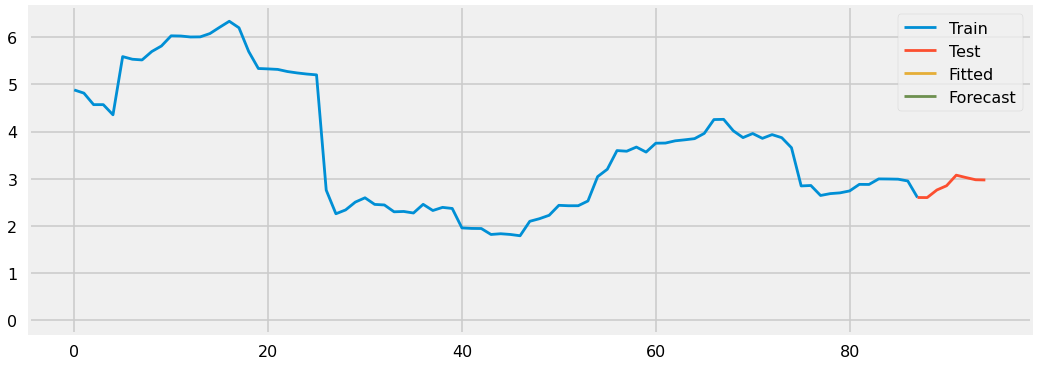

In [79]:
forecast_horizon = 7
df = df_month
df['daily_returns'] = np.log(df['Weighted_Price']).diff()
df['monthly_std'] = df['daily_returns'].rolling(21).std()   # Standard deviation across trading month
df['annual_vol'] = df['monthly_std'] * np.sqrt(252)         # Annualize monthly standard devation
df = df.dropna().reset_index(drop=True)
returns = df['daily_returns'] * 100

am = garch
res = fgarch

fitted = 0.1 * np.sqrt(
    res.params['omega'] +
    res.params['alpha[1]'] *
    res.resid**2 +
    res.conditional_volatility**2 *
    res.params['beta[1]']
)

forecast = 0.1 * np.sqrt(res.forecast().variance.values[-1])

# Store actual, fitted, and forecasted results
vol = pd.DataFrame({
    'actual': df['annual_vol'],
})

# Plot Actual vs Fitted/Forecasted
plt.figure(figsize=(16,6))
plt.plot(vol['actual'][:-forecast_horizon], label='Train')
plt.plot(vol['actual'][-forecast_horizon - 1:], label='Test')
plt.plot(forecast[:-forecast_horizon], label='Fitted')
plt.plot(forecast[-forecast_horizon - 1:], label='Forecast')
plt.legend()
plt.show()

In [78]:
rmse = np.sqrt(np.mean((vol['actual'] - forecast) ** 2))
rmse

3.7918634692116857

In [80]:
forecast[:-forecast_horizon]

array([], dtype=float64)

In [82]:
p = range(1, 5)
q = range(1, 5)

parameters = product(p, q)
parameters_list = list(parameters)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = arch_model(arima_model.resid, vol='GARCH', p=param[0], q=param[1])
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

sarimax_model = best_model
fgarch = garch.fit(disp='off') 
resid = fgarch.resid

AttributeError: ignored